# Khai Phá Và Tiền Xử Lý Dữ Liệu

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from PIL import Image
import random
import pandas as pd
from collections import Counter
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
import imghdr
import imagehash
from tqdm import tqdm

## 1. Số lượng dữ liệu đã thu nhập được

In [15]:
# Đường dẫn tới dữ liệu đã phân chia
DATA_DIR = Path("data/splits")
CLASSES = ["brown_spot","blast","bacterial_leaf_blight","normal"]
SPLITS = ["train", "val", "test"]
RESULTS_DIR = Path("results")

# Đảm bảo thư mục kết quả tồn tại
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir(parents=True)

# Đếm số lượng ảnh trong mỗi lớp và mỗi tập dữ liệu
counts = {}
for split in SPLITS:
    counts[split] = {}
    for cls in CLASSES:
        path = DATA_DIR / split / cls
        if path.exists():
            counts[split][cls] = len(list(path.glob("*")))
        else:
            counts[split][cls] = 0
            
df = pd.DataFrame(counts)
df["total"] = df.sum(axis=1)
df.loc["total"] = df.sum()
df

,train,val,test,total
brown_spot,3401,729,735,4865
blast,3414,725,734,4873
bacterial_leaf_blight,3464,739,746,4949
normal,3258,694,703,4655
total,13537,2887,2918,19342


### 1.1 Trực Quan Hoá Số Lượng Dữ Liệu

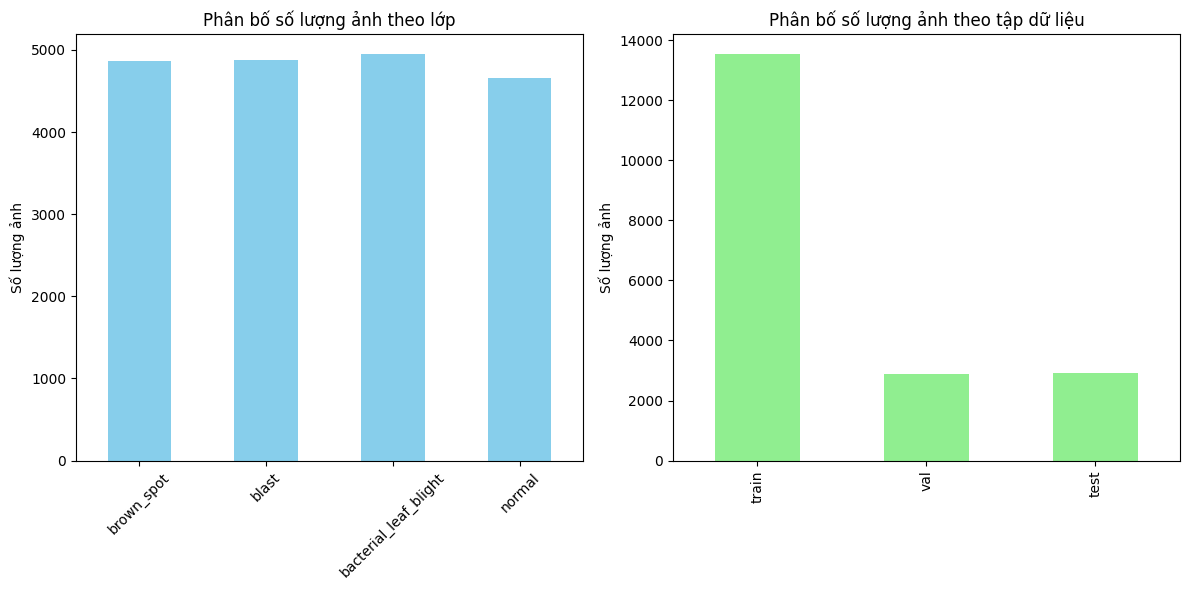

In [16]:
# Vẽ biểu đồ phân bố lớp và tập
plt.figure(figsize=(12, 6))

# Biểu đồ theo lớp
plt.subplot(1, 2, 1)
df.loc[CLASSES, "total"].plot(kind='bar', color='skyblue')
plt.title('Phân bố số lượng ảnh theo lớp')
plt.ylabel('Số lượng ảnh')
plt.xticks(rotation=45)

# Biểu đồ theo tập dữ liệu
plt.subplot(1, 2, 2)
df.loc["total", SPLITS].plot(kind='bar', color='lightgreen')
plt.title('Phân bố số lượng ảnh theo tập dữ liệu')
plt.ylabel('Số lượng ảnh')

plt.tight_layout()
plt.show()  # Chỉ hiển thị, không lưu file

## 1.2 Phân tích các thuộc tính của ảnh

In [17]:
# Phân tích các thuộc tính của ảnh: kích thước, kênh màu, độ sáng
sizes = []
aspect_ratios = []
brightness_values = []
class_data = {cls: {"sizes": [], "brightness": []} for cls in CLASSES}

# Lấy mẫu ngẫu nhiên từ tập train
samples = []
for cls in CLASSES:
    path = DATA_DIR / "train" / cls
    if path.exists():
        files = list(path.glob("*"))
        # Lấy tối đa 100 ảnh mỗi lớp để phân tích
        samples.extend(random.sample(files, min(100, len(files))))

for img_path in samples:
    try:
        # Đọc ảnh bằng OpenCV để phân tích
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        # Lấy thông tin kích thước
        h, w, c = img.shape
        sizes.append((w, h))
        aspect_ratios.append(w / h)

        # Tính độ sáng trung bình
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        brightness = np.mean(hsv[:, :, 2])
        brightness_values.append(brightness)

        # Lưu thông tin theo lớp
        cls = img_path.parent.name
        if cls in class_data:
            class_data[cls]["sizes"].append((w, h))
            class_data[cls]["brightness"].append(brightness)

    except Exception as e:
        print(f"Lỗi khi xử lý {img_path}: {e}")

# Phân tích kích thước
widths, heights = zip(*sizes)
print("\n===== PHÂN TÍCH KÍCH THƯỚC ẢNH =====")
print(f"Kích thước trung bình: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
print(f"Kích thước nhỏ nhất: {min(widths)} x {min(heights)}")
print(f"Kích thước lớn nhất: {max(widths)} x {max(heights)}")
print(f"Tỷ lệ khung hình trung bình: {np.mean(aspect_ratios):.2f}")


===== PHÂN TÍCH KÍCH THƯỚC ẢNH =====
Kích thước trung bình: 789.0 x 802.9
Kích thước nhỏ nhất: 64 x 64
Kích thước lớn nhất: 3120 x 3264
Tỷ lệ khung hình trung bình: 0.96


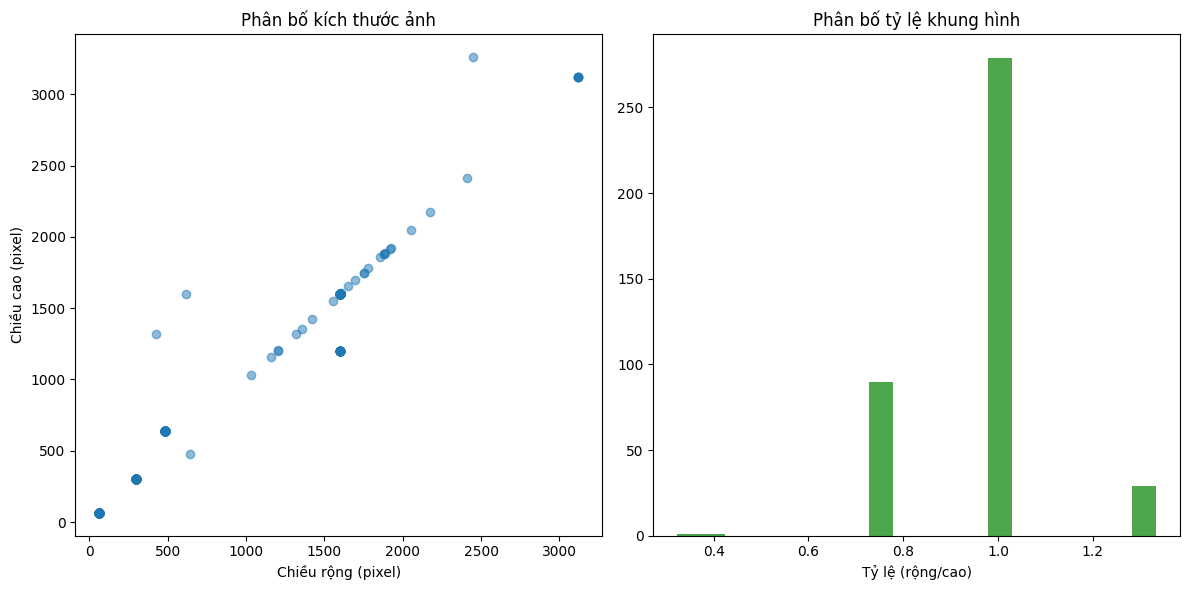

In [18]:
# Vẽ biểu đồ phân bố kích thước
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(widths, heights, alpha=0.5)
plt.title('Phân bố kích thước ảnh')
plt.xlabel('Chiều rộng (pixel)')
plt.ylabel('Chiều cao (pixel)')

plt.subplot(1, 2, 2)
plt.hist(aspect_ratios, bins=20, color='green', alpha=0.7)
plt.title('Phân bố tỷ lệ khung hình')
plt.xlabel('Tỷ lệ (rộng/cao)')
plt.tight_layout()
plt.show()  # Chỉ hiển thị, không lưu file

/tmp/ipykernel_167454/49124420.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=CLASSES)


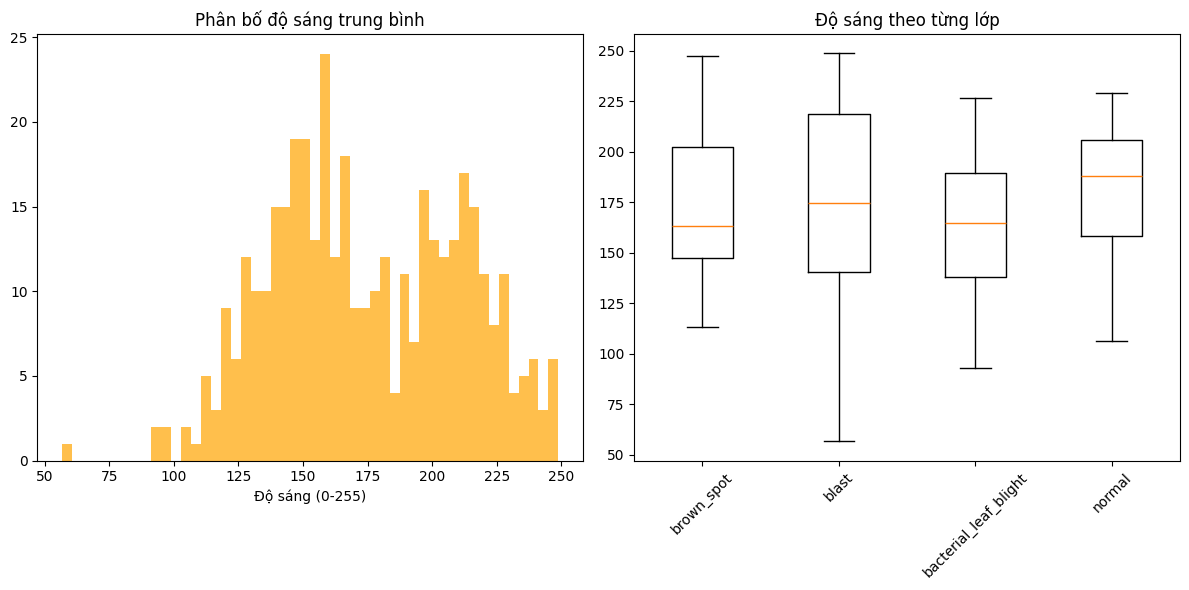

In [19]:
# Vẽ biểu đồ phân bố độ sáng
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(brightness_values, bins=50, color='orange', alpha=0.7)
plt.title('Phân bố độ sáng trung bình')
plt.xlabel('Độ sáng (0-255)')

plt.subplot(1, 2, 2)
boxplot_data = [class_data[cls]["brightness"] for cls in CLASSES]
plt.boxplot(boxplot_data, labels=CLASSES)
plt.title('Độ sáng theo từng lớp')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # Chỉ hiển thị, không lưu file

In [26]:
# Kiểm tra trùng lặp trong dữ liệu thô Rice_Leaf_Disease_Images và lưu ra TXT
RAW_DATA_DIR = Path("data/Rice_Leaf_Disease_Images")
RAW_CLASSES = ["bacterial_leaf_blight", "blast", "brown_spot", "normal"]


def check_duplicates_in_raw_dataset(
    root_dir: Path = RAW_DATA_DIR,
    classes = RAW_CLASSES,
    output_txt: Path = (RESULTS_DIR / "duplicate_images_raw.txt"),
    show_samples: bool = False,
):
    """Quét 4 thư mục lớp trong root_dir, phát hiện ảnh trùng bằng perceptual hash,
    và LƯU thông tin trùng lặp vào file TXT.

    Args:
        root_dir: Thư mục gốc chứa 4 lớp.
        classes: Danh sách tên lớp cần quét.
        output_txt: Đường dẫn file TXT để lưu kết quả.
        show_samples: Nếu True, hiển thị một vài cặp ảnh trùng lặp.
    """
    print("\n===== KIỂM TRA ẢNH TRÙNG LẶP (RAW DATASET) =====")
    if not root_dir.exists():
        print(f"Thư mục không tồn tại: {root_dir}")
        return []

    image_hashes = {}
    duplicates = []

    all_images = []
    for cls in classes:
        path = root_dir / cls
        if path.exists():
            all_images.extend([(file, cls) for file in path.glob("*") if file.is_file()])

    print(f"Đang kiểm tra {len(all_images)} ảnh trong {root_dir}...")

    for img_path, cls in tqdm(all_images, desc="Tính toán image hash"):
        try:
            img = Image.open(img_path).convert("RGB")
            h = str(imagehash.phash(img))

            if h in image_hashes:
                duplicates.append(
                    {
                        "hash": h,
                        "original": image_hashes[h],
                        "duplicate": {"path": str(img_path), "class": cls},
                    }
                )
            else:
                image_hashes[h] = {"path": str(img_path), "class": cls}
        except Exception as e:
            print(f"Lỗi khi xử lý {img_path}: {e}")

    # Báo cáo + lưu file TXT
    if duplicates:
        print(f"\nPhát hiện {len(duplicates)} cặp ảnh trùng lặp trong dữ liệu raw.")
        try:
            with open(output_txt, "w", encoding="utf-8") as f:
                for i, dup in enumerate(duplicates):
                    f.write(f"Cặp trùng lặp {i+1}:\n")
                    f.write(f"  Hash: {dup['hash']}\n")
                    f.write(
                        f"  Ảnh gốc: {dup['original']['path']} (Lớp: {dup['original']['class']})\n"
                    )
                    f.write(
                        f"  Ảnh trùng: {dup['duplicate']['path']} (Lớp: {dup['duplicate']['class']})\n\n"
                    )
            print(f"Đã lưu chi tiết vào: {output_txt}")
        except Exception as e:
            print(f"Lỗi khi ghi file {output_txt}: {e}")

        # Phân tích trùng lặp giữa các lớp
        cross_class_dups = [
            d for d in duplicates if d["original"]["class"] != d["duplicate"]["class"]
        ]
        if cross_class_dups:
            print(
                f"Có {len(cross_class_dups)} cặp ảnh trùng lặp giữa các lớp khác nhau (có thể gây lỗi gán nhãn)."
            )

        if show_samples:
            try:
                plt.figure(figsize=(12, 4 * min(5, len(duplicates))))
                for i, dup in enumerate(duplicates[:5]):
                    plt.subplot(min(5, len(duplicates)), 2, i * 2 + 1)
                    img1 = Image.open(dup["original"]["path"]).convert("RGB")
                    plt.imshow(img1)
                    plt.title(f"Gốc: {dup['original']['class']}")
                    plt.axis("off")

                    plt.subplot(min(5, len(duplicates)), 2, i * 2 + 2)
                    img2 = Image.open(dup["duplicate"]["path"]).convert("RGB")
                    plt.imshow(img2)
                    plt.title(f"Trùng: {dup['duplicate']['class']}")
                    plt.axis("off")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Lỗi khi hiển thị ảnh trùng lặp: {e}")
    else:
        print("Không phát hiện ảnh trùng lặp trong dữ liệu raw.")

    return duplicates

# Gợi ý chạy:
# duplicates_raw = check_duplicates_in_raw_dataset(show_samples=False)
# duplicates_raw[:3] if duplicates_raw else duplicates_raw

In [27]:
check_duplicates_in_raw_dataset(show_samples=False)


===== KIỂM TRA ẢNH TRÙNG LẶP (RAW DATASET) =====
Đang kiểm tra 19342 ảnh trong data/Rice_Leaf_Disease_Images...


Tính toán image hash: 100%|██████████| 19342/19342 [02:51<00:00, 112.46it/s]



Phát hiện 3007 cặp ảnh trùng lặp trong dữ liệu raw.
Đã lưu chi tiết vào: results/duplicate_images_raw.txt
Có 2 cặp ảnh trùng lặp giữa các lớp khác nhau (có thể gây lỗi gán nhãn).


[{'hash': 'd4a54a5b15650bbe',
  'original': {'path': 'data/Rice_Leaf_Disease_Images/bacterial_leaf_blight/BACTERAILBLIGHT3_042.jpg',
   'class': 'bacterial_leaf_blight'},
  'duplicate': {'path': 'data/Rice_Leaf_Disease_Images/bacterial_leaf_blight/BACTERIALBLIGHT1_043.jpg',
   'class': 'bacterial_leaf_blight'}},
 {'hash': 'd98fc69611393969',
  'original': {'path': 'data/Rice_Leaf_Disease_Images/bacterial_leaf_blight/BACTERIALBLIGHT_195.jpg',
   'class': 'bacterial_leaf_blight'},
  'duplicate': {'path': 'data/Rice_Leaf_Disease_Images/bacterial_leaf_blight/BACTERAILBLIGHT5_026.jpg',
   'class': 'bacterial_leaf_blight'}},
 {'hash': '9c96644d99e35d92',
  'original': {'path': 'data/Rice_Leaf_Disease_Images/bacterial_leaf_blight/BACTERIALBLIGHT2_053.jpg',
   'class': 'bacterial_leaf_blight'},
  'duplicate': {'path': 'data/Rice_Leaf_Disease_Images/bacterial_leaf_blight/BACTERAILBLIGHT5_221.jpg',
   'class': 'bacterial_leaf_blight'}},
 {'hash': 'cb2e5074614f1e5d',
  'original': {'path': 'data/

### 1.2.3 Xử lý dữ liệu bị trùng

## 1.3 Hiển thị một số mẫu từ mỗi lớp

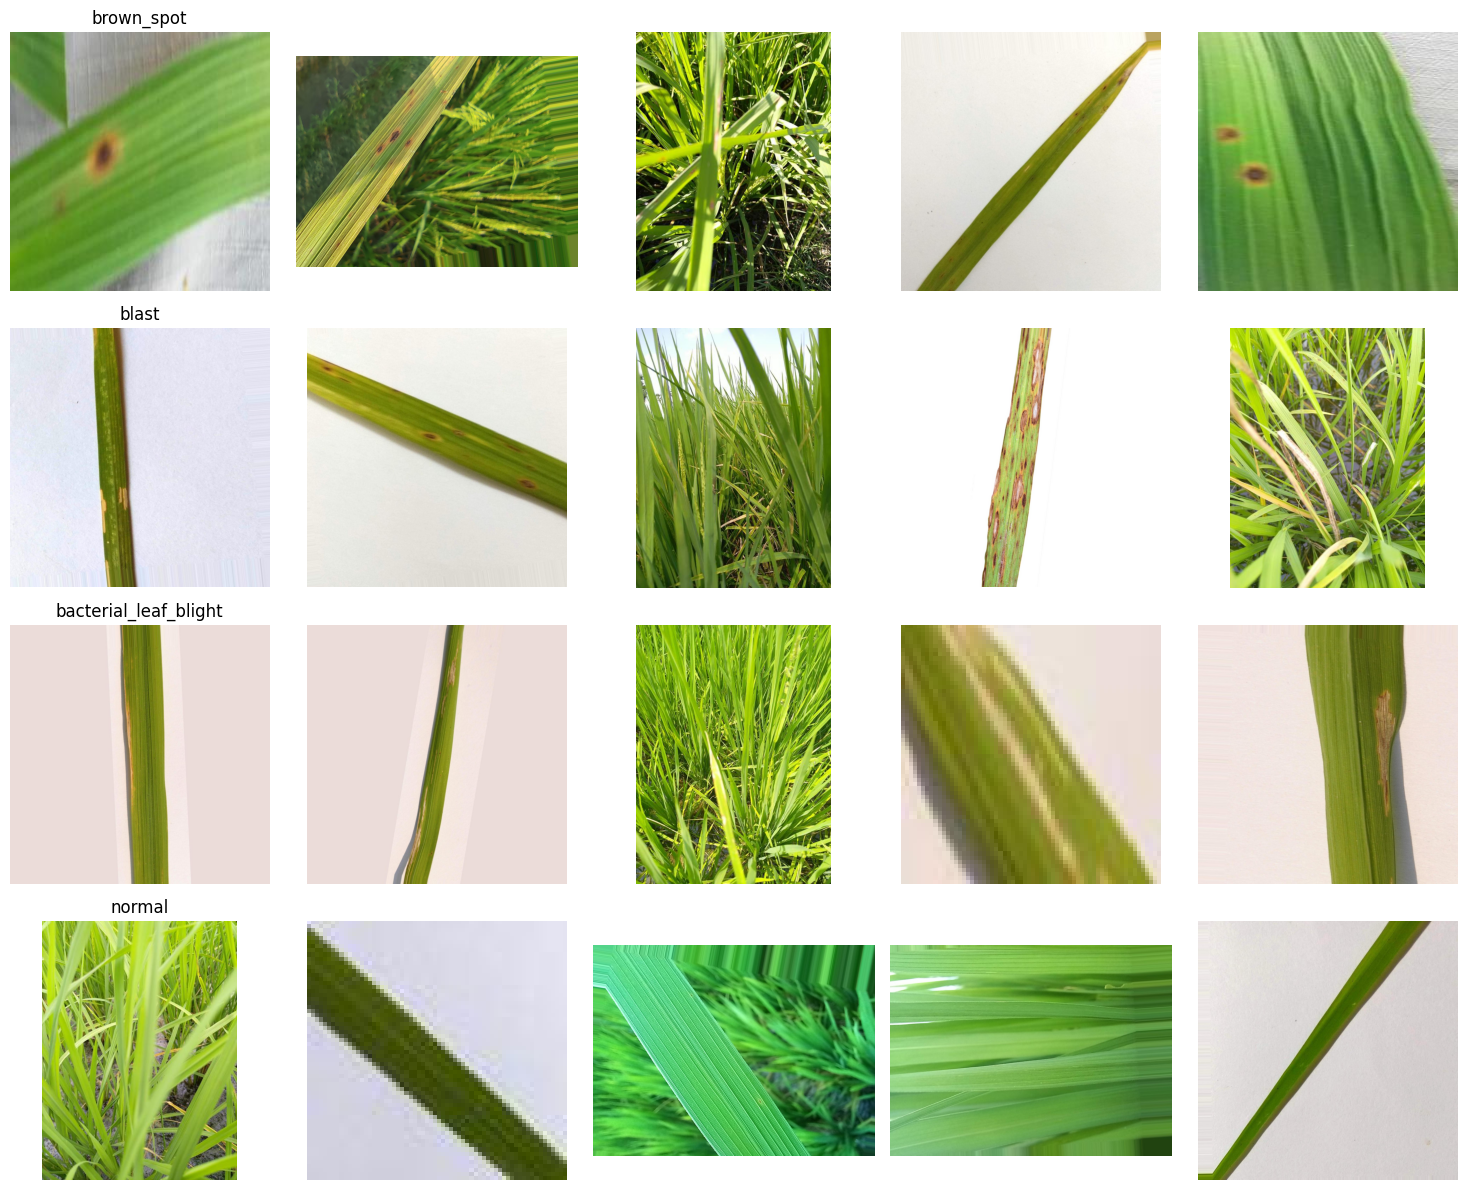

In [22]:
def visualize_samples():
    
    plt.figure(figsize=(15, 12))
    for i, cls in enumerate(CLASSES):
        path = DATA_DIR / "train" / cls
        if path.exists():
            files = list(path.glob("*"))
            # Lấy 5 ảnh mẫu mỗi lớp
            samples = random.sample(files, min(5, len(files)))
            
            for j, img_path in enumerate(samples):
                try:
                    img = Image.open(img_path)
                    plt.subplot(len(CLASSES), 5, i*5 + j + 1)
                    plt.imshow(img)
                    plt.axis('off')
                    if j == 0:
                        plt.title(cls)
                except Exception as e:
                    print(f"Lỗi khi hiển thị {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()  # Chỉ hiển thị, không lưu file
    
def main():
    visualize_samples()

if __name__ == "__main__":
    main()